In [46]:
#importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [47]:
#importing the data set
dataset = pd.read_csv('ML-EdgeIIoT-dataset.csv', low_memory=False)

X = dataset.iloc[:, 3:-2].values #Selecting colomns from index 3 to the second last column as features
Y = dataset.iloc[:, -1].values #Selecting the last column as label



In [48]:
print("Successfully loaded! Here is a tiny peek at the data:")
print(dataset.head())

# This line shows us how many 'Normal' vs 'Attack' rows we have
print("\nHow many of each type are in the file?")
print(dataset['Attack_type'].value_counts())

Successfully loaded! Here is a tiny peek at the data:
  frame.time    ip.src_host ip.dst_host arp.dst.proto_ipv4  arp.opcode  \
0        6.0  192.168.0.152         0.0                0.0         0.0   
1        6.0  192.168.0.101         0.0                0.0         0.0   
2        6.0  192.168.0.152         0.0                0.0         0.0   
3        6.0  192.168.0.101         0.0                0.0         0.0   
4        6.0  192.168.0.152         0.0                0.0         0.0   

   arp.hw.size arp.src.proto_ipv4  icmp.checksum  icmp.seq_le  \
0          0.0                0.0            0.0          0.0   
1          0.0                0.0            0.0          0.0   
2          0.0                0.0            0.0          0.0   
3          0.0                0.0            0.0          0.0   
4          0.0                0.0            0.0          0.0   

   icmp.transmit_timestamp  ...  mqtt.proto_len mqtt.protoname  mqtt.topic  \
0                      0.0  ... 

In [49]:
# Convert to a DataFrame
X_df = pd.DataFrame(X)

# Convert all text to numbers, turning errors into 'NaN'
X_df = X_df.apply(pd.to_numeric, errors='coerce')

# Replace 'Infinity' or '-Infinity' with 'NaN'
X_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill all NaNs with 0
X_df.fillna(0, inplace=True)

# This caps giant numbers at a safe limit for float32
X_df = X_df.clip(lower=-1e38, upper=1e38)

# Convert to float32 
X_clean = X_df.values.astype(np.float32)

# Convert back to a clean numpy array for the AI
X = X_df.values


In [50]:
# Encoding categorical data
from sklearn.preprocessing import LabelEncoder

# Turning names into numbers
le = LabelEncoder()
Y = le.fit_transform(Y)

In [52]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [53]:
#Feature Scaling
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [54]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, random_state = 42)
classifier.fit(X_train, Y_train)

Y_pred = classifier.predict(X_test)


In [55]:
from sklearn.tree import DecisionTreeClassifier

# 1. Initialize and Train
dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier.fit(X_train, Y_train)

# 2. Predict and Evaluate
Y_pred_dt = dt_classifier.predict(X_test)



In [56]:
from sklearn.neighbors import KNeighborsClassifier

# we use 5 neighbors as a standard starting point
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(X_train, Y_train)

Y_pred_knn = knn_classifier.predict(X_test)


In [57]:

from xgboost import XGBClassifier

# Initialize and Train
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train, Y_train)

# Predict
Y_pred_xgb = xgb_classifier.predict(X_test)

c:\Users\USER\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [01:27:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# List to store our final results
comparison_data = []

# List of all models we have trained
all_models = [
    ('Random Forest', classifier),
    ('Decision Tree', dt_classifier),
    ('KNN', knn_classifier),
    ('XGBoost', xgb_classifier)
    
]

for name, model in all_models:
    # Get predictions
    Y_pred_current = model.predict(X_test)
    
    # Calculate Overall Accuracy
    acc = accuracy_score(Y_test, Y_pred_current)
    
    # Calculate Precision, Recall, and F1 (using 'weighted' average for multi-class)
    precision, recall, f1, _ = precision_recall_fscore_support(Y_test, Y_pred_current, average='weighted')
    
    # Append to our list
    comparison_data.append({
        'Algorithm': name,
        'Accuracy (%)': acc * 100,
        'Precision (%)': precision * 100,
        'Recall (%)': recall * 100,
        'F1-Score (%)': f1 * 100
    })

# Create the final comparison table
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values(by='F1-Score (%)', ascending=False)

print("--- Final Model Comparative Analysis ---")
print(comparison_df.to_string(index=False))

--- Final Model Comparative Analysis ---
    Algorithm  Accuracy (%)  Precision (%)  Recall (%)  F1-Score (%)
      XGBoost     94.645120      95.426999   94.645120     94.862206
Random Forest     94.518378      95.234310   94.518378     94.731109
Decision Tree     93.897338      94.584786   93.897338     94.103307
          KNN     80.931559      80.997419   80.931559     80.702966


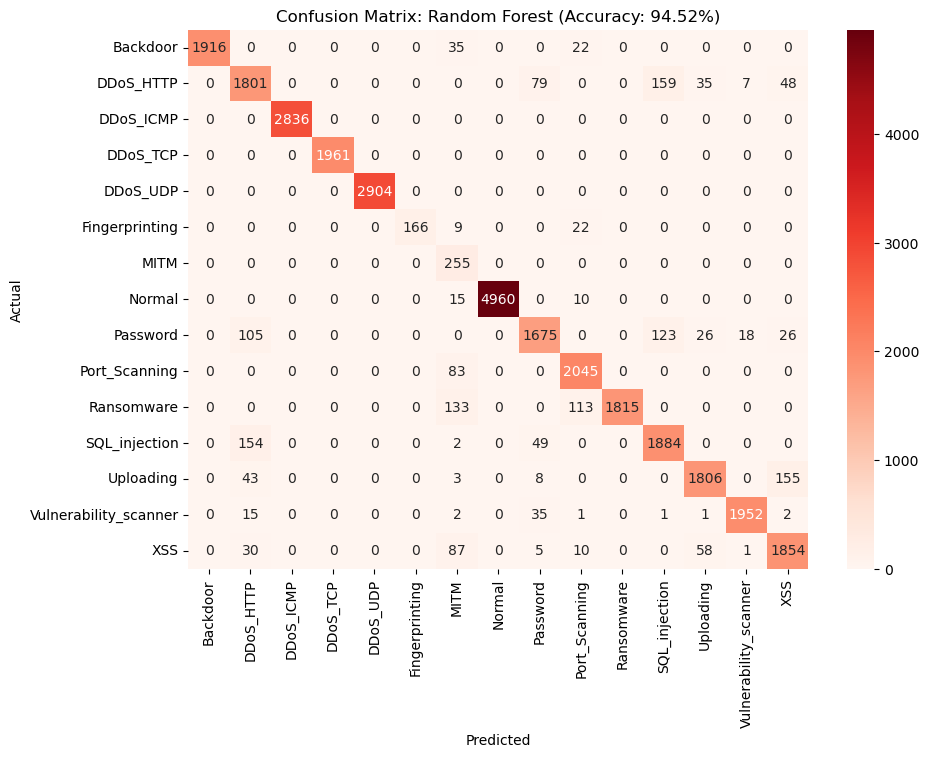

Random Forest analysis complete.
------------------------------


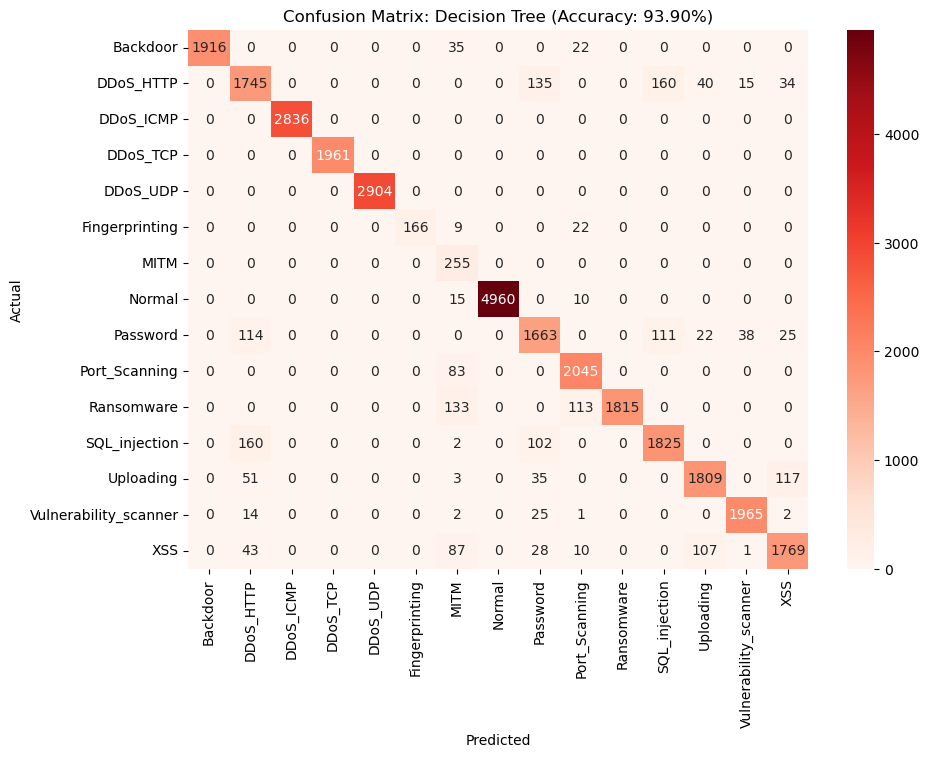

Decision Tree analysis complete.
------------------------------


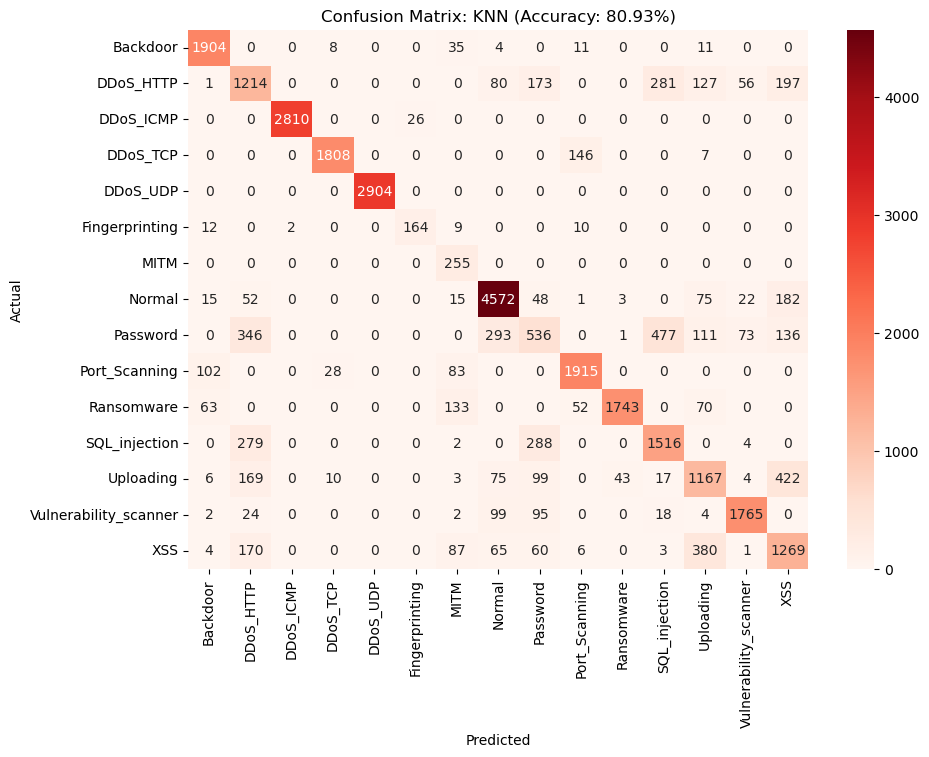

KNN analysis complete.
------------------------------


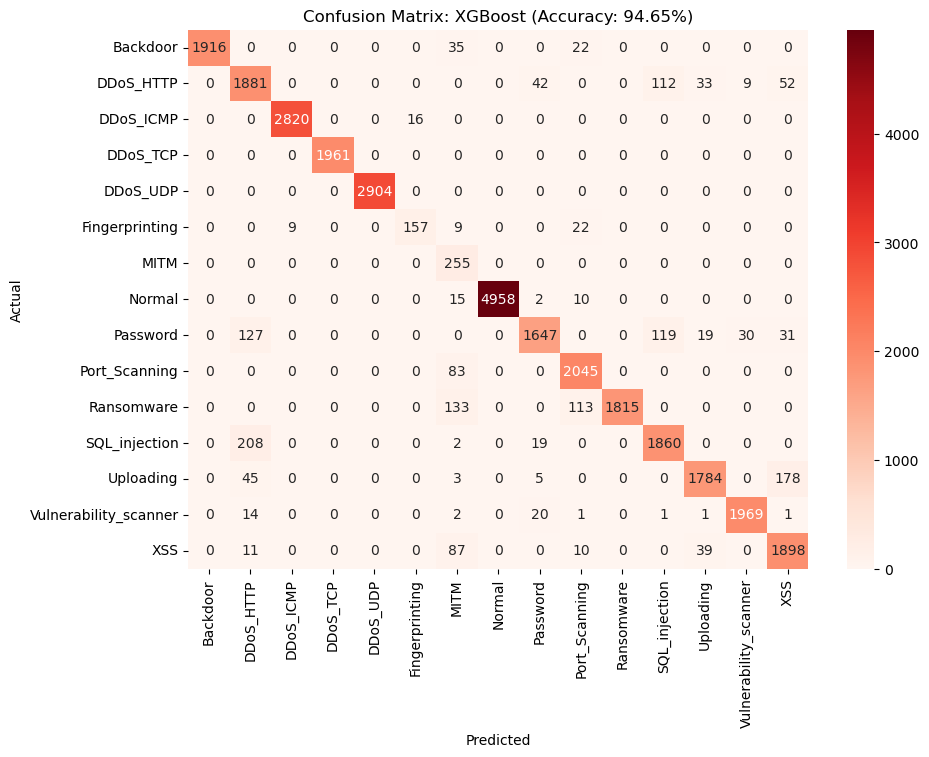

XGBoost analysis complete.
------------------------------


In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# 1. Define a list of our models
models = [
    ('Random Forest', classifier), 
    ('Decision Tree', dt_classifier),
    ('KNN', knn_classifier),
    ('XGBoost', xgb_classifier)
]

# 2. Loop through and plot
for name, model in models:
    # Get predictions
    Y_pred_current = model.predict(X_test)
    acc = accuracy_score(Y_test, Y_pred_current)
    
    # Calculate Confusion Matrix
    cm = confusion_matrix(Y_test, Y_pred_current)
    
    # Plotting
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Confusion Matrix: {name} (Accuracy: {acc*100:.2f}%)')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
    print(f"{name} analysis complete.\n" + "-"*30)